# A/B Testing Analysis in Python
## Kiran Jaura 
## EPPS 6317 Final

### A/B Testing:
* Used to understand whether a different version of something is the better alternative
    * Example: webpage design #1 vs webpage design #2
* Limit version change between A and B to ensure there are not multiple factors/interactions at play

### Assumptions:
* Observations are independent from each other
* Normal approximation of binomial distributions
    * Binomial because we are testing proportion of success or failure (binary)
        * Example: converted customer (0 or 1)
        
### Python App Limitations:
* Will read either csv or excel files
* Utilizing two-tailed Z test for only two groups for proportions specifically
* Need at least 30 observations per group due to normal approximation assumption

In [49]:
# Import modules
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import binom
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.stats.power as smp

In [50]:
# Prompt user for data
data = input("What is the file path for the data?")

What is the file path for the data?C:\Users\19728\Desktop\EPPS 6317\Final\cookie_cats.csv


In [51]:
# Read data - can work with either excel or csv files
while(True):
        if 'xls' in data[-4:]:
            read_file = pd.read_excel(data)
            print("Reading file.")
            break
        elif 'csv' in data[-3:]:
            read_file = pd.read_csv(data)
            print("Reading file.")
            break
        else:
            print("File not found.Please try again.")
            data = input("What is the file path for the data?")

Reading file.


# Check for Duplicate Rows

In [52]:
if read_file.duplicated().sum() != 0:
    print("Duplicate records found.")
else:
    print("No duplicate records found.")

No duplicate records found.


# Check for Unique ID Duplicates

In [53]:
columns = []
print("Columns:")
for col in read_file.columns:
    print(col.strip())
    columns.append(col.strip())
ids = input("Which column is a unique identifier of observations?")
while ids not in columns:
    print("Column not found. Please try again.")
    ids = input("Which column is a unique identifier of observations?")
else:
    for i in range(0,len(columns)):
        if columns[i] == ids:
            id_index = i
            id_column = read_file.iloc[:,id_index]
            if len(id_column) == len(set(id_column)):
                print("No duplicate " + ids + "s found.")
            else:
                print("Duplicates found. Please review dataset.")

Columns:
userid
version
sum_gamerounds
retention_1
retention_7
Which column is a unique identifier of observations?userid
No duplicate userids found.


# Prompt for Group Column 
## Check for 1 Control Group and 1 Test Group

In [58]:
columns = []
print("Columns:")
for col in read_file.columns:
    print(col.strip())
    columns.append(col.strip())
groups = input("Which column identifies the control and test groups?")
while groups not in columns:
    print("Column not found. Please try again.")
    groups = input("Which column identifies the control and test groups?")
else:
    if len(set(read_file[groups])) > 2:
        print("Cannot perform A/B test: Data contains more than 2 groups")
    elif len(set(read_file[groups])) < 2:
        print("Cannot perform A/B test: Data does not contain at least 2 groups")
    else:
        for j in range(0,len(columns)):
            if columns[j] == groups:
                group_index = j
                group_column = read_file.iloc[:,group_index]
                print("Now using '" + groups +"' for control/test group.")

Columns:
userid
version
sum_gamerounds
retention_1
retention_7
Which column identifies the control and test groups?version
Now using 'version' for control/test group.


## Get column for binomial outcome

In [71]:
columns = []
print("Columns:")
for col in read_file.columns:
    print(col.strip())
    columns.append(col.strip())
outcome = input("Which column displays the binomial outcome?")
while outcome not in columns:
    print("Column not found. Please try again.")
    outcome = input("Which column displays the binomial outcome?")
else:
    for k in range(0,len(columns)):
        if columns[k] == outcome:
            outcome_index = k
            outcome_column = read_file.iloc[:,outcome_index]
            print("Now using '" + outcome +"' as binary outcome variable.")

Columns:
userid
version
sum_gamerounds
retention_1
retention_7
Which column displays the binomial outcome?retention_1
Now using 'retention_1' as binary outcome variable.


## Ensure there are at least 30 observations per group

In [73]:
results = read_file.groupby(by=group_column).sum()
groupA = read_file[group_column == results.index[0]]
groupB = read_file[group_column == results.index[1]]
if len(groupA)<30 or len(groupB)<30:
    print("One or more groups have less than 30 observations. Need more observations (for normal approximation).")

## Get Proportions for Each Group

In [74]:
new_file = read_file.iloc[:,[group_index,outcome_index]]
new = pd.DataFrame()
new['success'] = new_file.groupby(by=[group_column]).sum()
new['total'] = pd.DataFrame(new_file.groupby(by=[group_column]).count().iloc[:,1])
pr_A = new['success'][0]/new['total'][0]
pr_B = new['success'][1]/new['total'][1]


ab_test = pd.concat([groupA, groupB], axis=0)
ab_test.reset_index(drop=True, inplace=True)
pr_A = groupA[outcome].mean()
pr_B = groupB[outcome].mean()
N_A = len(groupA)
N_B = len(groupB)
observations = N_A+N_B

print(str(new)+'\n')

print('A Proportion:\t' +str(round(pr_A,4)))
print('B Proportion:\t' +str(round(pr_B,4)))

         success  total
version                
gate_30    20034  44700
gate_40    20119  45489

A Proportion:	0.4482
B Proportion:	0.4423


# Set Confidence Level for Test
### For reducing chance of false positive

In [75]:
alpha = float(input('What significance level do you want to test (i.e. 0.05, 0.10, etc)?'))
print("Setting alpha to "+str(alpha)+".")

What significance level do you want to test (i.e. 0.05, 0.10, etc)?0.1
Setting alpha to 0.1.


# Calculate Statistical Power of Test
### For understanding chance of false negative

In [76]:
baseline = float(input("What's the baseline rate?"))
mde = float(input("What is the minimum detectable effect you are looking for \
(i.e. 0.01 change or 0.02 change)?"))
effect_size = sms.stats.proportion_effectsize(baseline,baseline+mde)    

power = smp.NormalIndPower().solve_power(effect_size, nobs1 = observations/2,alpha=alpha,ratio=1)                                      

print("Power of this test is: " +str(round(power,5)))

What's the baseline rate?.19
What is the minimum detectable effect you are looking for (i.e. 0.01 change or 0.02 change)?.1
Power of this test is: 1.0


## Results of test: z-statistic

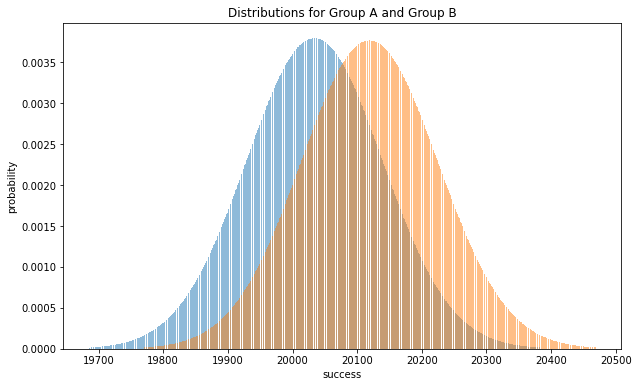

In [79]:
A = groupA[outcome].sum()
B = groupB[outcome].sum()
n_pr_A = 1-pr_A
n_pr_B = 1-pr_B

A_hat = A / N_A
B_hat = B / N_B

pooled_hat = (A + B)/(N_A + N_B)


fig, ax = plt.subplots(figsize=(10,6))
if A > 4000:
    minus = 349
    plus = 350
    tot = 700
else:
    minus = 99
    plus = 100
    tot = 200
xA = np.linspace(A-minus, A+plus, tot)
yA = stats.binom.pmf(xA,N_A,pr_A)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B-minus, B+plus, tot)
yB = stats.binom.pmf(xB,N_B,pr_B)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('success')
plt.ylabel('probability')
plt.title("Distributions for Group A and Group B")
plt.show()

Do not reject null hypothesis that there is no significant difference between proportions for A and B
Critical Z-Score: 	 1.64
Test Statistic: 	 1.4
Test P_value: 		 0.16
Confidence Interval
(of 2 sample Z-test):  [-0.001   0.0128]


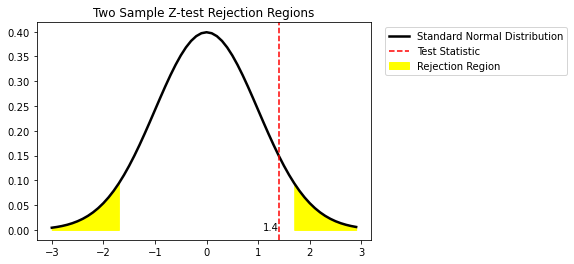

In [78]:
# Z test for proportions

# Pooled Standard Error 
pooled_SE = np.sqrt(pooled_hat*(1-pooled_hat) * (1/N_A + 1/B))

# critical value using the standard normal distribution
critical_z = stats.norm.ppf(1-alpha/2)

# test statistics
test_stat = round((A_hat - B_hat)/pooled_SE,2)

# Margin of error
m = pooled_SE * critical_z

# two sided test and using symmetry property of Normal distibution so we multiply with 2
p_value = stats.norm.sf(test_stat)*2

# Confidence Interval
CI = [(A_hat-B_hat) - pooled_SE * critical_z, (A_hat-B_hat) + pooled_SE * critical_z]

if np.abs(test_stat) >= critical_z:
    print("Reject null hypothesis that there is no significant difference between proportions for A and B")
    print(round(p_value,4))
else:
    print("Do not reject null hypothesis that there is no significant difference between proportions for A and B")


print("Critical Z-Score: \t", round(critical_z,2))
print("Test Statistic: \t", test_stat)
print("Test P_value: \t\t", round(p_value,2))
print("Confidence Interval\n(of 2 sample Z-test): ", np.round(CI,4))

z_range = np.arange(-3,3,  0.1)
plt.plot(z_range, stats.norm.pdf(z_range), label = 'Standard Normal Distribution',color = 'black',linewidth = 2.5)
plt.fill_between(z_range[z_range>critical_z], stats.norm.pdf(z_range[z_range>critical_z]),color ='yellow' )
plt.fill_between(z_range[z_range<(-1)*critical_z], stats.norm.pdf(z_range[z_range<(-1)*critical_z]), 
                 label = 'Rejection Region',color ='yellow' )
plt.axvline(test_stat, color = 'red',linestyle ='--',label='Test Statistic')
plt.text(test_stat, 0, test_stat,rotation=0, horizontalalignment='right')
plt.title("Two Sample Z-test Rejection Regions")
plt.legend(bbox_to_anchor=(1.6,1))
plt.show()

Data Source: 

https://www.kaggle.com/code/mursideyarkin/mobile-games-ab-testing-with-cookie-cats/data?select=cookie_cats.csv

References:
1. https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

2. https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
